**Remark**

It is possible to compare a Random Forest, Regression Tree, and an XGBoost model. The choice of the evaluation metric will depend on the specific problem and the goals of the model. Some commonly used evaluation metrics for regression models include:

- Mean Squared Error (MSE),  
- Mean Absolute Error (MAE), 
- R-squared (R²), 
- Median Absolute Error (MedAE),
- Mean Squared Log Error (MSLE).

If the goal is to minimize the prediction error, then MAE, MSE or RMSE could be used. 
On the other hand, if the goal is to have a more interpretable model, then the simpler models such as Regression Tree could be compared using the R² metric.

Therefore, the evaluation function should be chosen based on the problem and the goals of the model.

In [19]:
!pip install rdkit
!pip install bayesian-optimization
!pip install scikit-optimize
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
import xgboost as  xgb
import sklearn
from skopt import BayesSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
import statsmodels.api as sm
from statsmodels.formula.api import ols
from bayes_opt import BayesianOptimization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from google.colab import drive
import math
import rdkit
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import QED
from rdkit.Chem import MolSurf
from rdkit.Chem import rdFreeSASA as SASA
import os
import joblib
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
path = "/content/drive/My Drive/Toxicity Project/DATA/fingerprint_df.csv"
df = pd.read_csv(path)
df.head()

,index,Unnamed: 0.1,Unnamed: 0,id,title,common_name,description,cas,pubchem_id,chemical_formula,...,fp122,fp123,fp124,fp125,fp126,fp127,fp128,binary_rat_ld50,LD50_level,LD50_rat_level
0,0,0,0,2,T3D0001,Arsenic,Arsenic(As) is a ubiquitous metalloid found in...,7440-38-2,104734.0,As,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
1,1,1,3,5,T3D0004,Vinyl chloride,"Vinyl chloride is a man-made organic compound,...",75-01-4,6338.0,C2H3Cl,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0
2,2,2,4,7,T3D0006,Benzene,"Benzene is a toxic, volatile, flammable liquid...",71-43-2,241.0,C6H6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,3.0
3,3,3,5,8,T3D0007,Cadmium,Cadmium (group IIB of the periodic table of el...,7440-43-9,31193.0,Cd,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
4,4,5,9,13,T3D0012,Clofenotane,Insecticide. Clofenotane is a major component ...,50-29-3,3036.0,C14H9Cl5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [22]:
#=============Tokenize the Smiles Chemical data to machine code====================

class Dataset():
    def __init__(self, data, purpose, shuffle, fingerprint=True):
        super().__init__()
        self.data = data
        print("\n"+purpose.title())
        if fingerprint==False:
            #use tokens
            self.data = self.data_tokens()
        
        else:
            #use Morgan Fingerprints Bit Vectors
            self.data = self.data_fingers(bits=128)
        
        self.data = self.clearNANs()
        
        self.max_map = np.max(self.data[:,1:-9].flatten())
        self.n_map = len(np.unique(self.data[:,1:-9].flatten()))
        print(f"Largest embedding value: {self.max_map}")
        print(f"Number of unique embedding values: {self.n_map}")
        
        
        if shuffle:
            np.random.seed(42)
            np.random.shuffle(self.data,)

        if purpose == "train":
            self.data = self.data[:int(len(self.data)*0.7)]
        elif purpose == "all":
            self.data = self.data
        elif purpose == "val":     # I am not sure that I do it correct
            self.data = self.data[int(len(self.data)*0.7):]
        elif purpose == "test":
            try:
                self.data = pd.read_csv("DATA/test_df.csv")
            except:
                self.data = pd.read_csv("/content/drive/My Drive/Toxicity Project/DATA/test_df.csv")
        else:
            print("purpose must be one of: train, all, val, test.")
        
        self.x = self.data[:,1:-9]
        self.t = self.data[:,0]



        print(f"x shape: {self.x.shape}")
        print(f"t shape: {self.t.shape}")


    def data_fingers(self, bits):
        fingers = []
        ignore = 0
        for i, smile in enumerate(self.data.moldb_smiles):
            try:
                finger = Chem.MolFromSmiles(smile)
                finger = np.asarray(Chem.GetMorganFingerprintAsBitVect(finger,2,bits))
                props = self.properties(smile)
                finger = np.append(finger,props)
                ld = (float(self.data.loc[i,"LD50_rat"]))
                ld = np.array(ld)
                fingers.append(np.append(ld,finger))

            except TypeError: #necessary to ignore some of the molecules as they are chemically impossible 
                ignore+=1
                continue
        print(f"ignored: {ignore}")
        return np.stack(fingers)

    def data_tokens(self):
        tokens = []

        ignore = 0
        self.max_len = self.data.moldb_smiles.str.len().max()
        print(f"Length of longest string: {self.max_len}")
        
        for i, smile in enumerate(self.data.moldb_smiles):
            try:
                props = self.properties(smile)
                smile = smile + chr(0)*(self.max_len-len(smile)+1)#add 0-padding so that the lenght of the blocks is all the same (max_len+1)
                token = [ord(char) for char in list(smile)] # ord turns single character strings into a ASCII unicode value as such it can be used as an automatic  
                ld = (float(self.data.loc[i,"LD50_rat"]))
                ld = np.array(ld)
                token = np.array(token)
                token = np.append(token,props)
                tokens.append(np.append(ld,token))
            except TypeError: #necessary to ignore some of the molecules as they are chemically impossible 
                ignore+=1
                continue

        print(f"ignored: {ignore}")
        return np.stack(tokens)
    
    def clearNANs(self):
        ### There are still quite a lot of Nan's.
        ### The preprocessing code needs to be further cleaned up.
        nans = np.argwhere(np.isnan(self.data))
        print(f"N. of NaN's still present: {len(nans)}")
        print(f"Length of data before removing Nan's: {len(self.data)}")
        self.data = np.delete(self.data,nans[:,0].flatten(),0)
        print(f"Length of data after removing Nan's: {len(self.data)}")
        return self.data
    
    def properties(self, smile):
        mol = Chem.MolFromSmiles(str(smile))
        SA = MolSurf.LabuteASA(mol)
        props = list(QED.properties(mol)[:])
        props.append(SA)
        return props
    
    def make(self):
        return self.x, self.t
  

In [23]:
trainset = Dataset(data=df, purpose="train", shuffle=False)
X_train, t_train = trainset.make()


Train


[08:07:29] Explicit valence for atom # 0 O, 3, is greater than permitted


ignored: 1
N. of NaN's still present: 0
Length of data before removing Nan's: 563
Length of data after removing Nan's: 563
Largest embedding value: 1.0
Number of unique embedding values: 2
x shape: (394, 128)
t shape: (394,)


In [24]:
valset = Dataset(data=df, purpose="val", shuffle=False)
X_val, t_val = valset.make()


Val


[08:07:34] Explicit valence for atom # 0 O, 3, is greater than permitted


ignored: 1
N. of NaN's still present: 0
Length of data before removing Nan's: 563
Length of data after removing Nan's: 563
Largest embedding value: 1.0
Number of unique embedding values: 2
x shape: (169, 128)
t shape: (169,)


In [ ]:
#===========================XGBoost Regressor with Bayesian hyperparameter optimization===========================

def xgb_cv(n_estimators, max_depth, gamma, min_child_weight, subsample, data, targets):
    estimator = xgb.XGBRegressor(
        n_estimators=n_estimators,
        max_depth=int(max_depth),
        gamma=gamma,
        min_child_weight=min_child_weight,
        subsample=subsample,
        silent=1,
        objective='reg:squarederror'
    )
    cval = cross_val_score(estimator, data, targets, scoring='neg_mean_squared_error', cv=5)
    return cval.mean()

def optimize_xgb(data, targets):
    def xgb_crossval(n_estimators, max_depth, gamma, min_child_weight, subsample):
        return xgb_cv(
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            gamma=gamma,
            min_child_weight=min_child_weight,
            subsample=subsample,
            data=data,
            targets=targets
        )

    optimizer = BayesianOptimization(
        f=xgb_crossval,
        pbounds={
            'n_estimators': (1, 250),
            'max_depth': (1, 30),
            'gamma': (0.001, 1.0),
            'min_child_weight': (0.1, 10.0),
            'subsample': (0.4, 1.0)
        },
        random_state=1234,
        verbose=1
    )
    optimizer.maximize(n_iter=10)

    print("Final result:", optimizer.max)
    return optimizer.max

best = optimize_xgb(X_train, t_train)

|   iter    |  target   |   gamma   | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------
[08:01:42] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[08:01:44] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[08:01:45] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[08:01:46] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[08:01:47] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[08:01:48] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[08:01:49] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[08:01:50] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[08:01:50] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[08:01:51] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

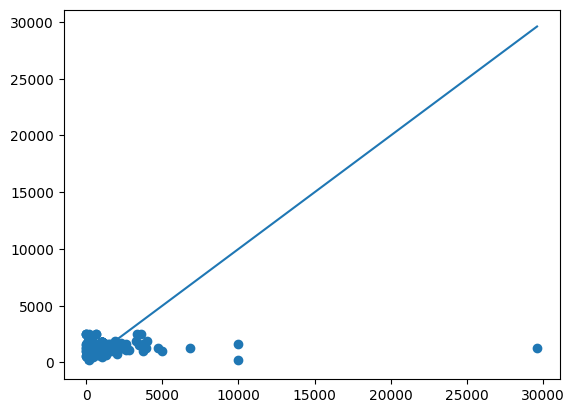

In [ ]:

search_space ={
            'n_estimators': (1, 250),
            'max_depth': (1, 30),
            'gamma': (0.001, 1.0),
            'min_child_weight': (0.1, 10.0),
            'subsample': (0.1, 1.0)
        }
est=xgb.XGBRegressor()
XGBreg = BayesSearchCV(
        est,
        search_space,
        n_iter=32,
        cv=5,
        n_jobs=-1,
        verbose=1
    )
XGBreg.fit(X_train, t_train)
XGBreg.score(X_val, t_val)
xg_pred = XGBreg.predict(X_val)
mse = sklearn.metrics.mean_squared_error(t_val,xg_pred)
print(f"MSE = {mse}")
mse_mean = np.mean((t_val-np.mean(t_val))**2)
print(f"MSE of mean = {mse_mean}")
print(f"R2 = {1-(mse/mse_mean)}")
plt.plot(np.linspace(min(t_val),max(t_val),3),np.linspace(min(t_val),max(t_val),3))
plt.scatter(t_val,xg_pred,)

In [ ]:
best["params"]

{'gamma': 0.8936136731280939,
 'max_depth': 9.603378608328628,
 'min_child_weight': 7.818666310404799,
 'n_estimators': 15.572407282267784,
 'subsample': 0.5026611356444753}

Performance XBG Regressor:
Mean Absolute Error: 2019.9450215537165 mg/kg
Benchmark: 2426.052028990581 mg/kg
R^2: -0.01775936463775163


['/content/drive/My Drive/Toxicity Project/Saved_models/XGB_Regressor.joblib']

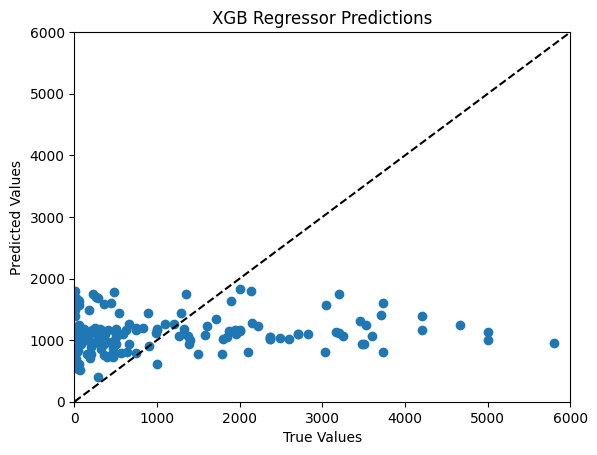

In [27]:
#=========XGBoost Regressor with best parameters=================

XGBreg = xgb.XGBRegressor(eval_metric='rmsle')
XGBreg=xgb.XGBRegressor(learning_rate = 0.1,
                           gamma = best["params"]["gamma"],
                           min_child_weight = int(best["params"]["min_child_weight"]),
                           n_estimators = int(best["params"]["n_estimators"]),
                           max_depth = int(best["params"]["max_depth"]),
                           subsample = best["params"]["subsample"],
                           eval_metric='rmsle')

XGBreg.fit(X_train, t_train)
XGBreg.score(X_val, t_val)
xg_pred = XGBreg.predict(X_val)

mae = sklearn.metrics.mean_absolute_error(t_val,xg_pred)
mae_mean = np.mean(abs(t_val-np.mean(t_val)))
r2 = sklearn.metrics.r2_score(t_val, xg_pred)

print("Performance XBG Regressor:")
print("Mean Absolute Error:", mae, "mg/kg")
print("Benchmark:", mae_mean, "mg/kg")
print("R^2:", r2)

plt.plot(np.linspace(0,15,3),np.linspace(0,15,3))
plt.plot([t_val.min(), t_val.max()], [t_val.min(), t_val.max()], linestyle='--', color='k')
plt.title("XGB Regressor Predictions")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.scatter(t_val,xg_pred,)
plt.xlim(0,6000)
plt.ylim(0,6000)

#joblib.dump(XGBreg,"/content/drive/My Drive/Toxicity Project/Saved_models/XGB_Regressor.joblib")

In [ ]:
#==========Evaluation functions XGBoost================

#mse 
mse = sklearn.metrics.mean_squared_error(t_val, xg_pred)
#R2
r2 = sklearn.metrics.r2_score(t_val, xg_pred)
#Mean absolute error 
mae = sklearn.metrics.mean_absolute_error(t_val, xg_pred)
#median absolute error 
medae = sklearn.metrics.median_absolute_error(t_val, xg_pred)
#mse log error 
#msle = sklearn.metrics.mean_squared_log_error(t_val, xg_pred)

print("Mean squared error:", mse)
print("R-squared score:", r2)
print("Mean absolute error:", mae)
print("Median absolute error:", medae)
#print("Mean squared logarithmic error:", msle)

Mean squared error: 5104223.096255772
R-squared score: 0.25386815172602106
Mean absolute error: 879.209048118817
Median absolute error: 430.60369873046875


Performance Regression Tree:
Mean Absolute Error: 2855.8982248520706 mg/kg
Benchmark: 2426.052028990581 mg/kg
R^2: -0.12188361338073173


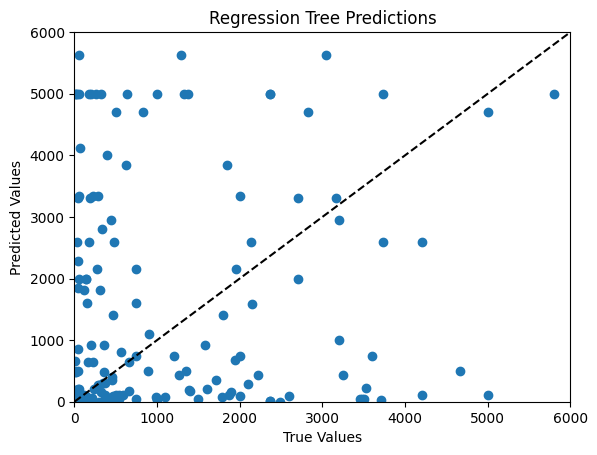

['/content/drive/My Drive/Toxicity Project/Saved_models/Regression_Tree.joblib']

In [25]:
#=======Regression tree============

reg_tree = DecisionTreeRegressor()
reg_tree.fit(X_train, t_train)
rt_pred = reg_tree.predict(X_val)

mae = mean_absolute_error(t_val, rt_pred)
mae_mean = np.mean(abs(t_val-np.mean(t_val)))
r2 = sklearn.metrics.r2_score(t_val, rt_pred)

print("Performance Regression Tree:")
print("Mean Absolute Error:", mae, "mg/kg")
print("Benchmark:", mae_mean, "mg/kg")
print("R^2:", r2)

plt.scatter(t_val, rt_pred)
plt.ylim(0,6000)
plt.xlim(0,6000)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Regression Tree Predictions")
plt.plot([t_val.min(), t_val.max()], [t_val.min(), t_val.max()], linestyle='--', color='k')
plt.show()

#joblib.dump(reg_tree,"/content/drive/My Drive/Toxicity Project/Saved_models/Regression_Tree.joblib")

In [ ]:
#==========Evaluation functions regression tree================

#mse 
tmse = sklearn.metrics.mean_squared_error(t_val, rt_pred)
#R2
tr2 = sklearn.metrics.r2_score(t_val, rt_pred)
#Mean absolute error 
tmae = sklearn.metrics.mean_absolute_error(t_val, rt_pred)
#median absolute error 
tmedae = sklearn.metrics.median_absolute_error(t_val, rt_pred)
#mse log error 
tmsle = sklearn.metrics.mean_squared_log_error(t_val, rt_pred)

print("Mean squared error:", tmse)
print("R-squared score:", tr2)
print("Mean absolute error:", tmae)
print("Median absolute error:", tmedae)
print("Mean squared logarithmic error:", tmsle)


Mean squared error: 4718402.674247205
R-squared score: -2.827173457865698
Mean absolute error: 467.4901380670612
Median absolute error: 0.0
Mean squared logarithmic error: 1.0007202785389864


Performance Random Forest:
Mean Absolute Error: 2307.2544006452526 mg/kg
Benchmark: 2426.052028990581 mg/kg
R^2: -0.05163603528161276


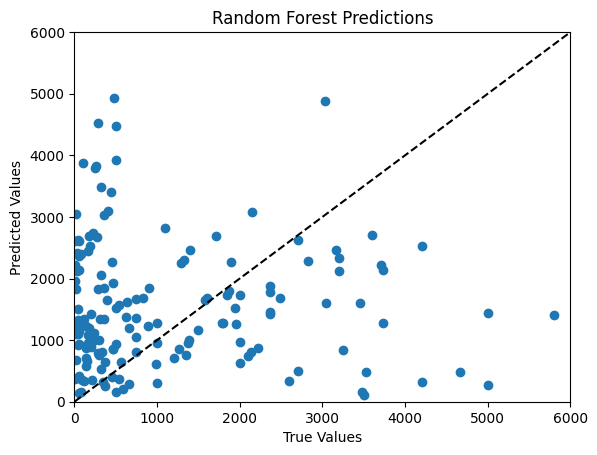

['/content/drive/My Drive/Toxicity Project/Saved_models/RandomForest_Regressor.joblib']

In [26]:
#========Random forest==============

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, t_train)

rf_pred = rf.predict(X_val)
mae = mean_absolute_error(t_val, rf_pred)
mae_mean = np.mean(abs(t_val-np.mean(t_val)))
r2 = sklearn.metrics.r2_score(t_val, rf_pred)

print("Performance Random Forest:")
print("Mean Absolute Error:", mae, "mg/kg")
print("Benchmark:", mae_mean, "mg/kg")
print("R^2:", r2)

plt.scatter(t_val, rf_pred)
plt.xlim(0,6000)
plt.ylim(0,6000)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest Predictions")
plt.plot([t_val.min(), t_val.max()], [t_val.min(), t_val.max()], linestyle='--', color='k')
plt.show()

#joblib.dump(rf,"/content/drive/My Drive/Toxicity Project/Saved_models/RandomForest_Regressor.joblib")

In [ ]:
#==========Evaluation functions random forest================

#mse 
rfmse = sklearn.metrics.mean_squared_error(t_val, rf_pred)
#R2
rfr2 = sklearn.metrics.r2_score(t_val, rf_pred)
#Mean absolute error 
rfmae = sklearn.metrics.mean_absolute_error(t_val, rf_pred)
#median absolute error 
rfmedae = sklearn.metrics.median_absolute_error(t_val, rf_pred)
#mse log error 
rfmsle = sklearn.metrics.mean_squared_log_error(t_val, rf_pred)

print("Mean squared error:", rfmse)
print("R-squared score:", rfr2)
print("Mean absolute error:", rfmae)
print("Median absolute error:", rfmedae)
print("Mean squared logarithmic error:", rfmsle)


Mean squared error: 1349688.8128843075
R-squared score: 0.8717814436298508
Mean absolute error: 538.441100138067
Median absolute error: 177.6164900000001
Mean squared logarithmic error: 1.4370255284548035


**Anova**

The following Anova table only confirms that the three different models are statistically different.

In [ ]:
#=======ANOVA implementation=========

#Compute residuals
xgb_resid = t_val - xg_pred
rt_resid = t_val - rt_pred
rf_resid =  t_val - rf_pred

# Create dataframe of residuals 
resid_df = df = pd.DataFrame({"xgb_resid": xgb_resid, "rt_resid": rt_resid, "rf_resid": rf_resid})

# Create ANOVA table
anova_model = ols('xgb_resid ~ rt_resid + rf_resid', data=resid_df).fit()

# Print ANOVA table
print(sm.stats.anova_lm(anova_model, typ=2))


                sum_sq     df           F        PR(>F)
rt_resid  1.796365e+07    1.0   31.563582  7.982043e-08
rf_resid  1.352496e+08    1.0  237.644465  7.508172e-34
Residual  9.447491e+07  166.0         NaN           NaN
